* index: timestamp in ms
* BDEP: bit depth in m
* TPO: fluid flow in gpm
* HL: hook load in klbf
* BHT: block position in m
* RPM: rotary speed in rpm
* TOR: torque in klbf-ft
* DEPT: hole depth in m
* WOB: weight on bit in klbf

# Importing and installing libs

In [ ]:
%%capture
!pip install pycaret

#Pycaret use an old version of Scikit-learn, so in front on this notebook i'll update the lib to use the sequential feature selection.

In [ ]:
%%capture
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

from collections import Counter
from imblearn.combine import SMOTETomek 

from sklearn.preprocessing import Normalizer
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data loading and adjusting 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Viasat_challenge/data/challenge_data.csv')
label = pd.read_csv('/content/drive/MyDrive/Viasat_challenge/data/challenge_annotation.csv')

In [ ]:
data.rename(columns={'Unnamed: 0': 'TS'}, inplace = True)
# data['TS'] = pd.to_numeric(data['TS'], downcast='float')
data.head()

TS      BDEP        TPO          HL     BHT  RPM  TOR      DEPT  \
0  1.607131e+12  5063.135  19.548731  522.503986  18.982  0.0  0.0  5795.817   
1  1.607131e+12  5063.135  15.586150  523.159986  19.068  0.0  0.0  5795.817   
2  1.607131e+12  5062.959  18.492043  524.441986  19.164  0.0  0.0  5795.817   
3  1.607131e+12  5062.959  16.114494  525.053986  19.249  0.0  0.0  5795.817   
4  1.607131e+12  5062.778  17.699526  526.081986  19.347  0.0  0.0  5795.817   

     WOB  
0  13.38  
1  12.73  
2  11.45  
3  10.84  
4   9.81

In [ ]:
label.rename(columns={'Unnamed: 0': 'TS'}, inplace = True)
# label['TS'] = pd.to_numeric(label['TS'], downcast='float')
label.head()

TS Annotation
0  1.607131e+12  off_slips
1  1.607131e+12   on_slips
2  1.607131e+12  off_slips
3  1.607131e+12   on_slips
4  1.607131e+12  off_slips

Concating the the challenge_data.csv and challenge_annotation.csv in one Pandas dataset.

In [ ]:
df = pd.concat([data, label])
df.sort_values(by ='TS', inplace=True, ignore_index=True)
df['Annotation'] = df['Annotation'].fillna(-1)

Labeling all samples based on the stage change points given in challenge_annotation.csv

In [ ]:
states = ['off_slips', 'on_slips']

actual_state = states[0]

for x, y in enumerate(df['Annotation']):
    if y == -1:
      df['Annotation'][x] = actual_state
    if y == 'off_slips':
      actual_state = states[0]
    if y == 'on_slips':
      actual_state = states[1]

Dataset summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40782 entries, 0 to 40781
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TS          40782 non-null  float64
 1   BDEP        40673 non-null  float64
 2   TPO         40660 non-null  float64
 3   HL          40671 non-null  float64
 4   BHT         40658 non-null  float64
 5   RPM         40647 non-null  float64
 6   TOR         40656 non-null  float64
 7   DEPT        40651 non-null  float64
 8   WOB         40651 non-null  float64
 9   Annotation  40782 non-null  object 
dtypes: float64(9), object(1)
memory usage: 3.1+ MB


In [ ]:
df.describe()

TS          BDEP           TPO            HL           BHT  \
count  4.078200e+04  40673.000000  40660.000000  40671.000000  40658.000000   
mean   1.607141e+12   4128.110895      6.970594    322.494967     20.995525   
std    5.871748e+06    566.009203     35.477067    157.447630     13.364818   
min    1.607131e+12   3055.281000      0.000000     80.455998      1.694000   
25%    1.607136e+12   3636.986000      0.000000     97.413997      7.635000   
50%    1.607141e+12   4179.829000      0.000000    394.129990     22.199000   
75%    1.607146e+12   4610.241000      0.000000    445.305988     33.103250   
max    1.607151e+12   5063.135000    204.469157    528.517986     39.987000   

           RPM      TOR       DEPT           WOB  
count  40647.0  40656.0  40651.000  40651.000000  
mean       0.0      0.0   5795.817    109.278085  
std        0.0      0.0      0.000    155.015235  
min        0.0      0.0   5795.817    -10.760000  
25%        0.0      0.0   5795.817      1.760000  
50%        0.0      0.0   5795.817      6.600000  
75%        0.0      0.0   5795.817    293.090000  
max        0.0      0.0   5795.817    451.030000

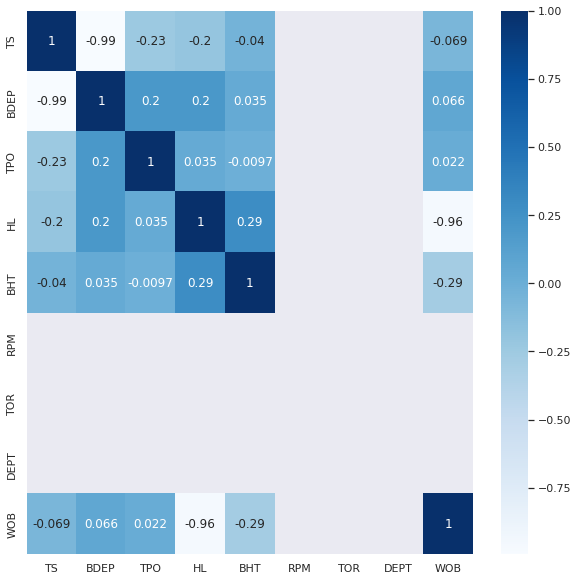

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues')

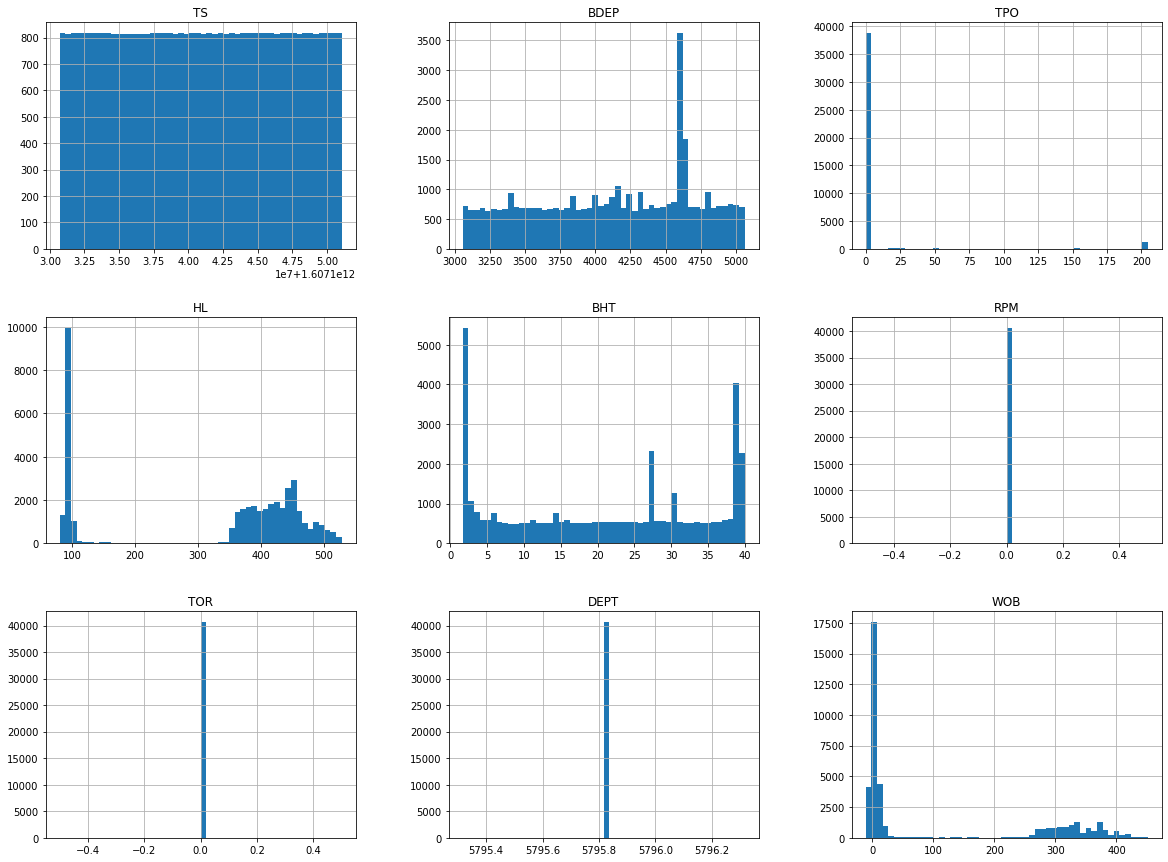

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Filling the missing values with a interpolation method, that is the best way to do considering the data was captured as a temporal serie. This techniques estimate the missing values by assuming a relationship within a range of data points, using past and future known data points. Due to the nature of these data, i chose use the time option, giving more importance to nearby points than far away points.

In [ ]:
columns = ['BDEP', 'TPO', 'HL', 'BHT', 'RPM', 'TOR', 'DEPT', 'WOB']

for x in columns:
   df[f'{x}'].interpolate(option='time', inplace=True, limit_direction='both', limit_area='inside')

We have a profile of the dataset that can be also visualized as a web page, the file is in this folder "/dataIntelieByViasatReport.html"

In [ ]:
report = ProfileReport(df, title='Intellie by Viasat Report',
                       html={'style': {'full_width':True}},
                       explorative=True,
                       missing_diagrams={'bar':True}
                       )

report.to_notebook_iframe()
report.to_file('/content/drive/MyDrive/Viasat_challenge/dataIntelieByViasatReport.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Considering that "RPM", "TOR" and "DEPT" features have a constant value, i'll not use them in the models and analysis. 

# Exploring high correlations

## **Hook Load** (HL) <> **Weight on Bit** (WOB)

- **Hook Load** correspond to the total force pulling down on the hook. That means Hook load is a very important parameter used during drilling operations to control the weight on bit and to assess possible deteriorations of the downhole conditions such as poor hole cleaning or excessive tortuosity. 

- **Weight on Bit** is the amount of downward force exerted on the drill bit.

Text(0, 0.5, 'Hook Load')

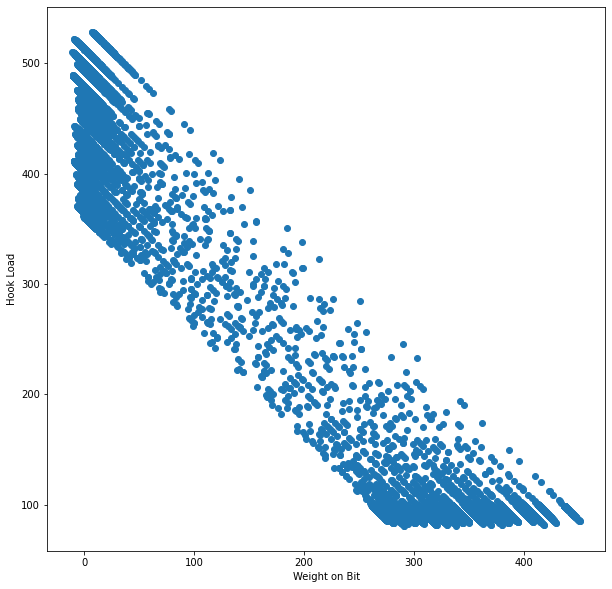

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x='WOB',y='HL',data=df)
plt.xlabel('Weight on Bit')
plt.ylabel('Hook Load')

So we can see that the high correlation between HL and WOB derivate from a linear function representing the behavior that the more the force pulling down on the hook grows, the greater the weight on the drill bit.

## **Block Position** (BHT) and **Hook Load** (HL) <> **Annotation**

- **Bloc Position** is the center position of a three-position control valve.
- **Hook Load** correspond to the total force pulling down on the hook. That means Hook load is a very important parameter used during drilling operations to control the weight on bit and to assess possible deteriorations of the downhole conditions such as poor hole cleaning or excessive tortuosity. 
- **Annotation** Just label if the drill pipe is with or without the Slips.

<Figure size 720x720 with 0 Axes>

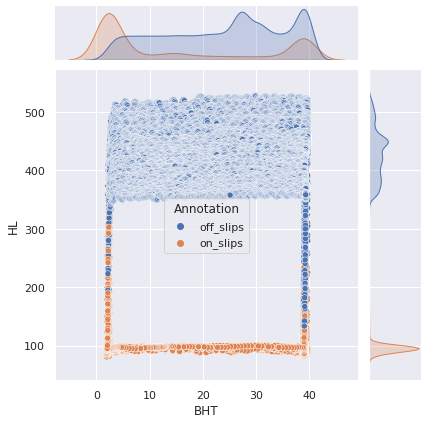

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(data=df, x="BHT", y="HL", hue="Annotation")

We can see that exist an clear correlation between the presence of Slips and the Hook Load. Practically in all the range of positions that the block can be, there is a threshold that marks the presence or absence of slips (approximately 250m). Except at the end of the range, which seems to lack slips beyond its range, but which could possibly be marked because of the end of the process.we can see that normally, the HL opperate with greater force than approximately 350klbf or 100klbf under.

## **Timestamp** (TS) <> **Bit Depth** (BDEP)

- **Timestamp** represent the moment in ms that was captured the values of the features 
- **Bit Depth** correspond to the bit depth in m

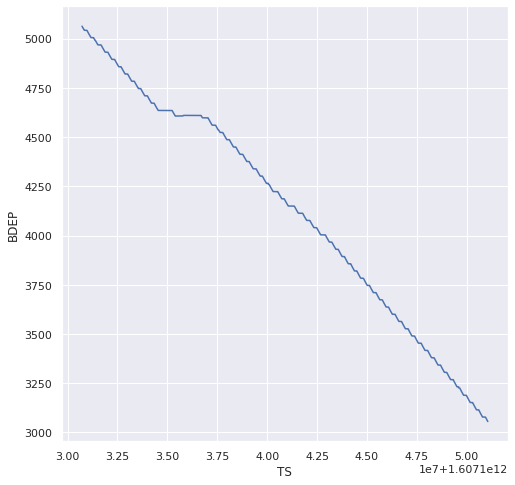

In [ ]:
plt.figure(figsize=(8,8))
sns.lineplot(data=df, x="TS", y="BDEP")

In [ ]:
df['DEPT'].unique()

array([5795.817])

We can see from the graph that the bit drill is in the process of decreasing depth, which means that it is being removed from the earth. This idea also match with the DEPT(hole dept in m) feature always repeat the same high value, meaning that probably the drilling process was finished. 

## **Fluid flow** (TPO)

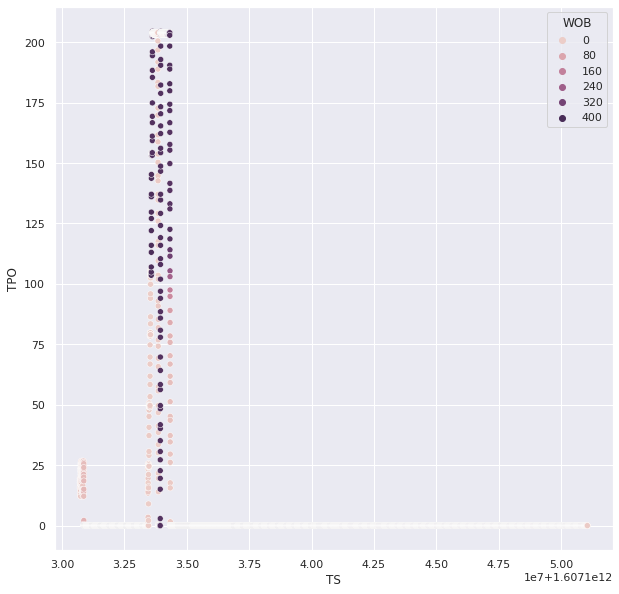

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="TS", y="TPO", hue="WOB")

Here we can see that the fluid flow is greater mainly when the downward force exerted on the drill bit is higher. As the wob is high, so is the friction between the drill bit and the ground. To be able to continue drilling, a higher fluid flow makes sense.

# Statistical properties over time

##Searching for noises

### Positive results for ACF test

In [ ]:
df.head()

TS      BDEP        TPO          HL     BHT  RPM  TOR      DEPT  \
0  1607130720314  5063.135  19.548731  522.503986  18.982  0.0  0.0  5795.817   
1  1607130720822  5063.135  15.586150  523.159986  19.068  0.0  0.0  5795.817   
2  1607130721329  5062.959  18.492043  524.441986  19.164  0.0  0.0  5795.817   
3  1607130721838  5062.959  16.114494  525.053986  19.249  0.0  0.0  5795.817   
4  1607130722346  5062.778  17.699526  526.081986  19.347  0.0  0.0  5795.817   

     WOB Annotation  
0  13.38  off_slips  
1  12.73  off_slips  
2  11.45  off_slips  
3  10.84  off_slips  
4   9.81  off_slips

In [ ]:
acf_analysis = df.drop(['RPM', 'TOR', 'DEPT', 'Annotation'], axis=1)


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on TS


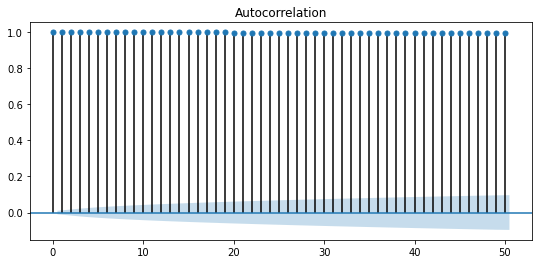


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on BDEP


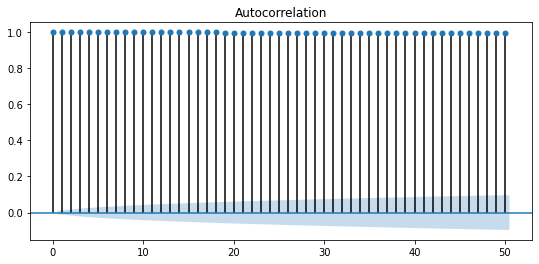


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on TPO


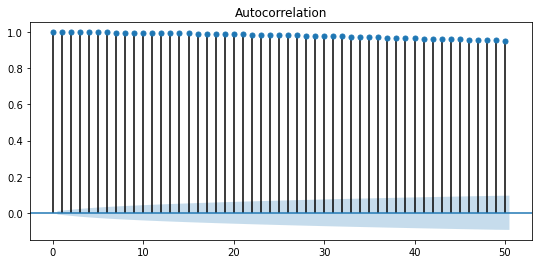


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on HL


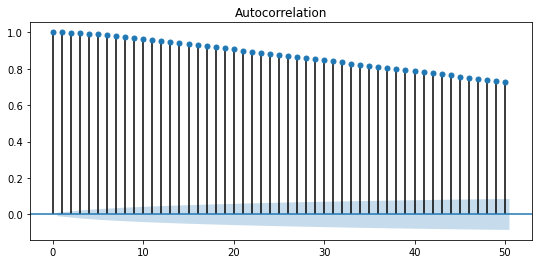


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on BHT


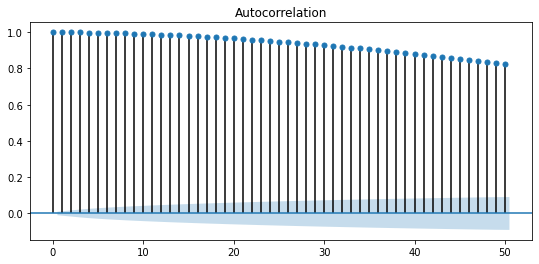


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on WOB


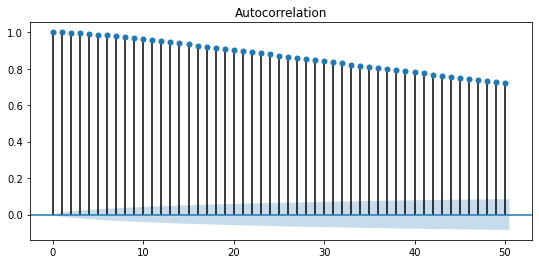

In [ ]:
for x in acf_analysis:
  print('\n','-='*32)
  print(f'Autocorrelation Function on {x}')

  rcParams["figure.figsize"] = 9, 4
  fig = plot_acf(acf_analysis[f'{x}'], lags=50)

  plt.show();

We can assure that the correlation of this features is statistically significant because the Pearson’s correlation coefficient at each lag(represented by the height of the bars) is outside the blue shaded region(confidence interval)


### Negative results for ACF test

In [ ]:
acf_noise_analysis = df[['RPM', 'TOR', 'DEPT']]


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on RPM


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


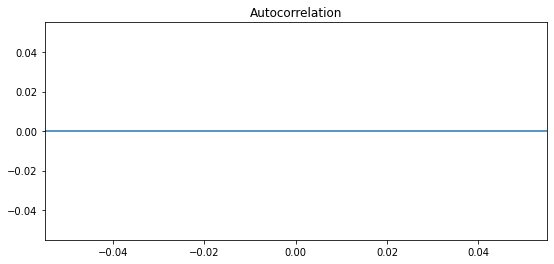


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on TOR


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


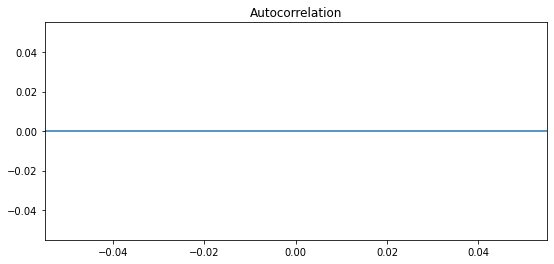


 -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Autocorrelation Function on DEPT


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


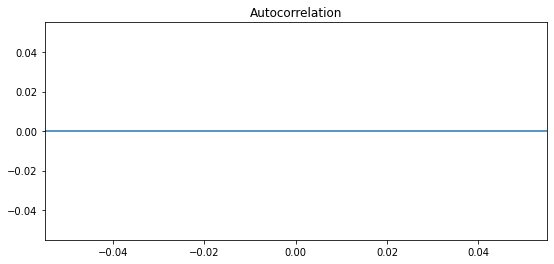

In [ ]:
for x in acf_noise_analysis:
  print('\n','-='*32)
  print(f'Autocorrelation Function on {x}')

  rcParams["figure.figsize"] = 9, 4
  fig = plot_acf(acf_noise_analysis[f'{x}'], lags=50)

  plt.show();

### Veryfing if there is any white noise

In short, white noise distribution is any distribution that has:

- Zero mean
- A constant variance/standard deviation (does not change over time)
- Zero autocorrelation at all lags


In [ ]:
df.describe()

TS          BDEP           TPO            HL           BHT  \
count  4.078200e+04  40782.000000  40782.000000  40782.000000  40782.000000   
mean   1.607141e+12   4127.955793      6.994606    322.342489     20.995069   
std    5.871748e+06    566.059411     35.537872    157.370683     13.380541   
min    1.607131e+12   3055.281000      0.000000     80.455998      1.694000   
25%    1.607136e+12   3636.986000      0.000000     97.431997      7.594000   
50%    1.607141e+12   4179.454000      0.000000    393.950990     22.205000   
75%    1.607146e+12   4610.241000      0.000000    445.259988     33.137500   
max    1.607151e+12   5063.135000    204.469157    528.517986     39.987000   

           RPM      TOR       DEPT           WOB  
count  40782.0  40782.0  40782.000  40782.000000  
mean       0.0      0.0   5795.817    109.435770  
std        0.0      0.0      0.000    154.939045  
min        0.0      0.0   5795.817    -10.760000  
25%        0.0      0.0   5795.817      1.770000  
50%        0.0      0.0   5795.817      6.640000  
75%        0.0      0.0   5795.817    292.937500  
max        0.0      0.0   5795.817    451.030000

All the three variables "RPM", "TOR" and "DEPT" have white noise, RPM and TOR have mean 0 and DEPT have the same value repeting, meaning a constant variance/standard deviation. In addition to these points, these features have 0 autocorrelation at all tags.

### Veryfing if theres is random walk noise problem

Even random walk noise problem being a more challenging but equally unpredictable distribution in time series forecasting and unlike white noise, it has non-zero mean, non-constant std/variance, and when plotted, looks a lot like a regular distribution, we can see if there's any looking for the ACF test, the acf of a random walk does return non-zero correlations. This truth is due the nature of the data where each step is dependent on the previous step. Random Walk formula (V_t = V_t-1 + noise)

## Verifying Stationarity

Check if the statistical properties of a a time series(or the process generating it) do not change over time.

In [ ]:
check_stationarity = df.set_index('TS')

to detecting stationarity in our time series data i'll use a unit root test,
Dickey-Fuller. Augmented Dickey-Fuller(ADF) will test the null hypothesis that a unit root is present in an autoregressive model of our time serie, and that the process is thus not stationary. 

In [ ]:
def isStationary(timeserie):
  dftest = adfuller(pd.Series(check_stationarity[f'{timeserie}']), autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test statistics', 'p-value', 'maximized information criteria', 'Number of samples used'])
  for key, value in dftest[4].items():
    dfoutput['Critical value (%s)'%key] = value

  if(dfoutput['Test statistics'] < dfoutput['Critical value (5%)'] and dfoutput['p-value'] < 0.05):
    print(' -', timeserie, 'is Stationary')
  else:
    print(' -', timeserie, 'is not Stationary')

In [ ]:
for column in check_stationarity:
  if column != 'Annotation':
    isStationary(column)

 - BDEP is not Stationary
 - TPO is Stationary
 - HL is Stationary
 - BHT is Stationary


/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


 - RPM is not Stationary


/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


 - TOR is not Stationary


/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


 - DEPT is not Stationary
 - WOB is Stationary


In the stationarity verification test, we see that we have 4 features that were rejected ("BDEP", "RPM", "TOR", "DEPT"). For this features i'll drop the last 3 ("RPM", "TOR" and "DEPT") because they have constant values that will not aggregate any in our model. For the "BDEP" feature, let's transform it in a stationary serie. 

To transform BDEP feature serie is a stationary serie i'll use the diferetitation method. Creating a new serie from the difference between t sample and the t-1 sample. Differentiating also remove the temporal dependence of a serie, reducing the tendence and sazonality. If it is necessary, we will differentiate more than one time.

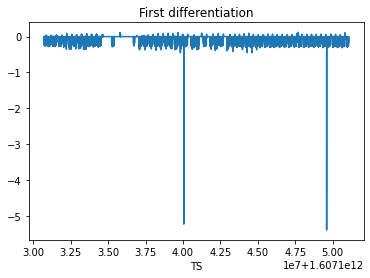

 -BDEP is Stationary


In [ ]:
  dfdiff = check_stationarity.BDEP.diff()
  dfdiff = dfdiff.dropna()
  plt.title('First differentiation')
  dfdiff.plot()
  plt.show()

  dftest = adfuller(dfdiff, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test statistics', 'p-value', 'maximized information criteria', 'Number of samples used'])
  for key, value in dftest[4].items():
    dfoutput['Critical value (%s)'%key] = value

  if(dfoutput['Test statistics'] < dfoutput['Critical value (5%)'] and dfoutput['p-value'] < 0.05):
    print(' -BDEP', 'is Stationary')
  else:
    print(' -BDEP', 'is not Stationary')

In [ ]:
check_stationarity['BDEP'] = dfdiff 
check_stationarity = check_stationarity.drop(['RPM', 'TOR', 'DEPT'], axis=1)

If all the univariate time series in an dataset are stationary, then the dataset is stationary.So we can assure that now the dataset is stationary.


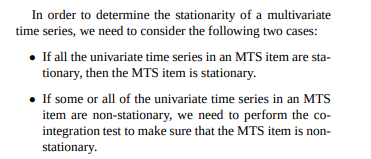 




for more info, check this article: [On the Stationarity of Multivariate Time Series for Correlation-Based Data Analysis. ](https://infolab.usc.edu/DocsDemos/05-868.pdf)

In [ ]:
df

TS   BDEP        TPO          HL     BHT    WOB Annotation
0      1.607131e+12    NaN  19.548731  522.503986  18.982  13.38  off_slips
1      1.607131e+12  0.000  15.586150  523.159986  19.068  12.73  off_slips
2      1.607131e+12 -0.176  18.492043  524.441986  19.164  11.45  off_slips
3      1.607131e+12  0.000  16.114494  525.053986  19.249  10.84  off_slips
4      1.607131e+12 -0.181  17.699526  526.081986  19.347   9.81  off_slips
...             ...    ...        ...         ...     ...    ...        ...
40777  1.607151e+12 -0.180   0.000000  358.541991  24.768   2.46  off_slips
40778  1.607151e+12  0.000   0.000000  358.595991  24.856   2.40  off_slips
40779  1.607151e+12  0.000   0.000000  358.605991  24.940   2.39  off_slips
40780  1.607151e+12 -0.172   0.000000  358.411991  25.038   2.59  off_slips
40781  1.607151e+12  0.000   0.000000  357.757991  25.123   3.24  off_slips

[40782 rows x 7 columns]

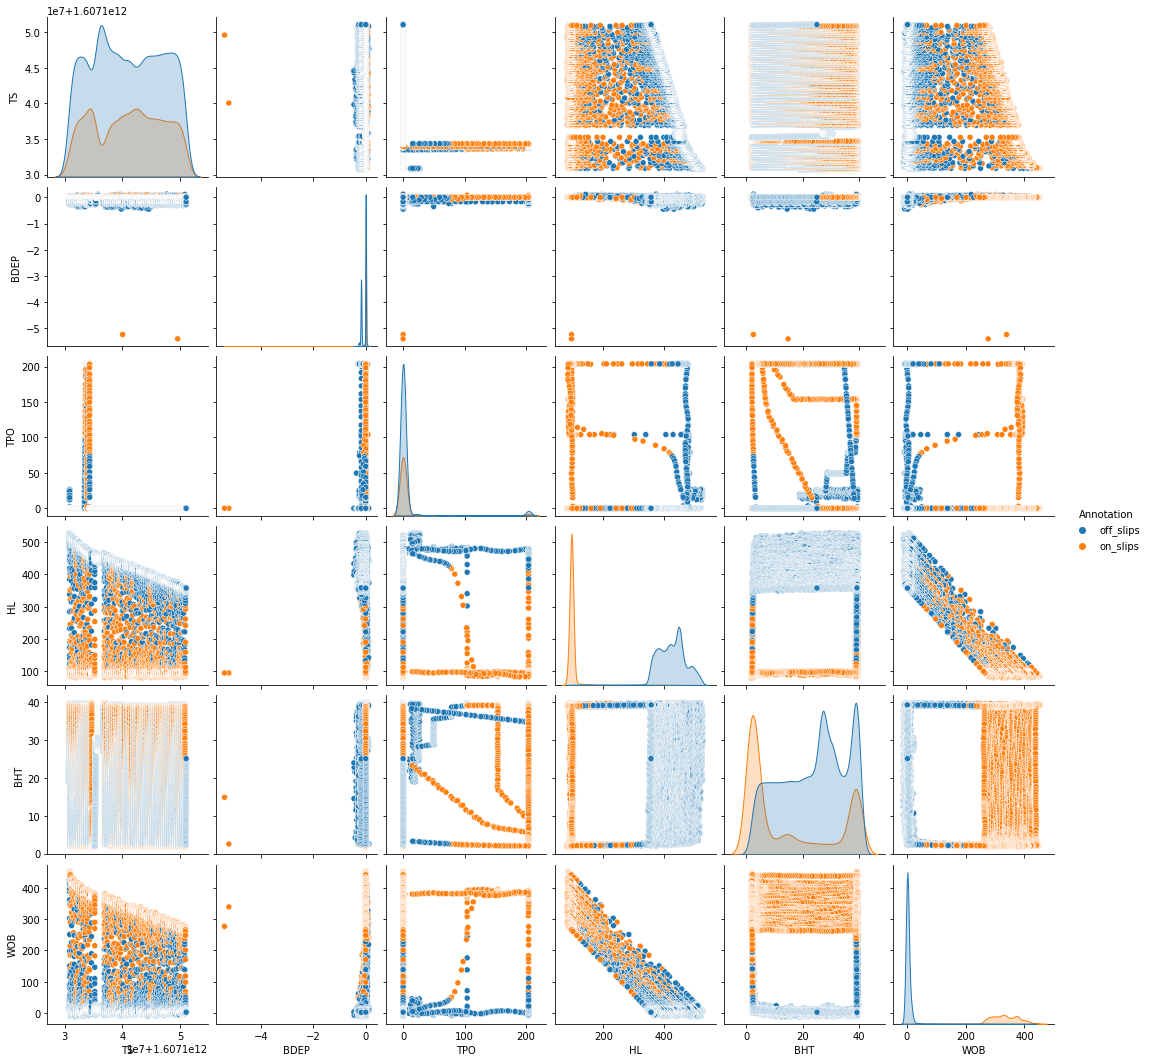

In [ ]:
sns.pairplot(df, hue='Annotation')

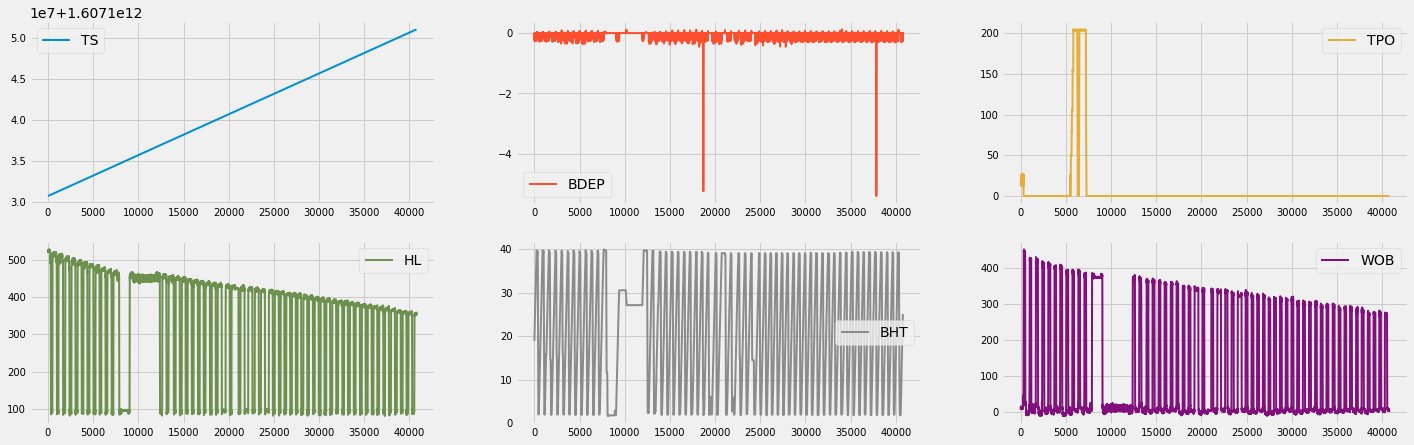

In [ ]:
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False
)
plt.show()

In [ ]:
df = check_stationarity
df.to_csv('/content/drive/MyDrive/Viasat_challenge/data/dataset_v2.csv')

# Classification Models

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Viasat_challenge/data/dataset_v2.csv')

In [ ]:
df['TS'] = df['TS'].apply(lambda d: datetime.datetime.fromtimestamp(d/1000.0))

In [ ]:
df = df.set_index('TS')

In [ ]:
df['Annotation'] = df['Annotation'].replace(['on_slips', 'off_slips'], [1, 0])

## Binary Classification with PyCaret

In [ ]:
# sample 5% of data to be used as unseen data
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

# print the revised shape
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))


Data for Modeling: (38743, 6)
Unseen Data For Predictions: (2039, 6)


In [ ]:
from pycaret.classification import *
s = setup(data = data, target = 'Annotation', session_id=123, use_gpu=True)

Description             Value
0                               session_id               123
1                                   Target        Annotation
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data        (38743, 6)
5                           Missing Values              True
6                         Numeric Features                 5
7                     Categorical Features                 0
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set        (27120, 5)
12                    Transformed Test Set        (11623, 5)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              cc76
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='Annotation', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_s...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best_model = compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9930  0.9995  0.9891  0.9890   
et                 Extra Trees Classifier    0.9926  0.9995  0.9889  0.9882   
gbc          Gradient Boosting Classifier    0.9924  0.9997  0.9885  0.9877   
lr                    Logistic Regression    0.9923  0.9992  0.9875  0.9884   
lightgbm  Light Gradient Boosting Machine    0.9922  0.9997  0.9871  0.9886   
ada                  Ada Boost Classifier    0.9916  0.9997  0.9846  0.9891   
knn                K Neighbors Classifier    0.9912  0.9980  0.9868  0.9859   
qda       Quadratic Discriminant Analysis    0.9910  0.9963  0.9875  0.9845   
dt               Decision Tree Classifier    0.9909  0.9896  0.9859  0.9859   
nb                            Naive Bayes    0.9907  0.9960  0.9871  0.9840   
ridge                    Ridge Classifier    0.9906  0.0000  0.9847  0.9861   
lda          Linear Discriminant Analysis    0.9906  0.9974  0.9847  0.9860   
svm                   SVM - Linear Kernel    0.9844  0.0000  0.9884  0.9684   
dummy                    Dummy Classifier    0.6789  0.5000  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
rf        0.9890  0.9838  0.9839     2.025  
et        0.9885  0.9831  0.9831     0.889  
gbc       0.9881  0.9825  0.9825     3.021  
lr        0.9879  0.9822  0.9822     0.338  
lightgbm  0.9879  0.9821  0.9822     0.212  
ada       0.9868  0.9806  0.9806     0.784  
knn       0.9863  0.9799  0.9799     0.433  
qda       0.9860  0.9793  0.9793     0.068  
dt        0.9859  0.9792  0.9792     0.056  
nb        0.9856  0.9787  0.9787     0.021  
ridge     0.9854  0.9785  0.9785     0.030  
lda       0.9853  0.9784  0.9784     0.094  
svm       0.9772  0.9655  0.9668     0.216  
dummy     0.0000  0.0000  0.0000     0.014

INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [ ]:
models()

INFO:logs:gpu_param set to True


Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
lightgbm  Light Gradient Boosting Machine   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [ ]:
rf = create_model('rf')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9937  0.9996  0.9908  0.9897  0.9902  0.9856  0.9856
1       0.9941  0.9998  0.9851  0.9965  0.9908  0.9864  0.9865
2       0.9915  0.9989  0.9885  0.9851  0.9868  0.9806  0.9806
3       0.9945  0.9998  0.9943  0.9886  0.9914  0.9873  0.9873
4       0.9930  0.9992  0.9874  0.9908  0.9891  0.9839  0.9839
5       0.9941  0.9999  0.9920  0.9897  0.9908  0.9865  0.9865
6       0.9915  0.9992  0.9885  0.9851  0.9868  0.9806  0.9806
7       0.9912  0.9998  0.9885  0.9840  0.9863  0.9797  0.9797
8       0.9945  0.9999  0.9908  0.9920  0.9914  0.9873  0.9873
9       0.9915  0.9992  0.9851  0.9885  0.9868  0.9805  0.9805
Mean    0.9930  0.9995  0.9891  0.9890  0.9890  0.9838  0.9839
Std     0.0013  0.0003  0.0028  0.0035  0.0020  0.0030  0.0030

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
tuned_rf = tune_model(rf)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9926  0.9998  0.9943  0.9830  0.9886  0.9831  0.9832
1       0.9945  0.9998  0.9920  0.9908  0.9914  0.9873  0.9873
2       0.9893  0.9997  0.9908  0.9762  0.9835  0.9756  0.9756
3       0.9900  0.9998  0.9943  0.9752  0.9847  0.9773  0.9774
4       0.9904  0.9997  0.9954  0.9753  0.9852  0.9781  0.9782
5       0.9934  0.9998  0.9954  0.9841  0.9897  0.9848  0.9849
6       0.9908  0.9994  0.9920  0.9796  0.9857  0.9789  0.9790
7       0.9904  0.9997  0.9920  0.9785  0.9852  0.9781  0.9781
8       0.9937  0.9999  0.9977  0.9830  0.9903  0.9857  0.9857
9       0.9926  0.9996  0.9920  0.9852  0.9886  0.9831  0.9831
Mean    0.9918  0.9997  0.9936  0.9811  0.9873  0.9812  0.9813
Std     0.0017  0.0001  0.0021  0.0048  0.0026  0.0039  0.0038

INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


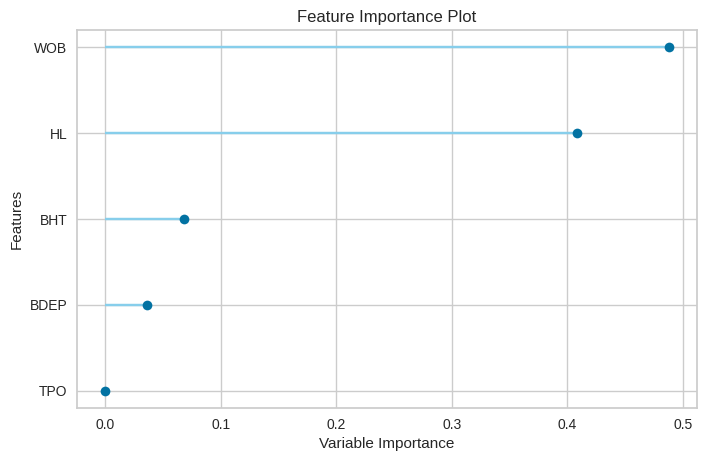

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf, plot='feature')

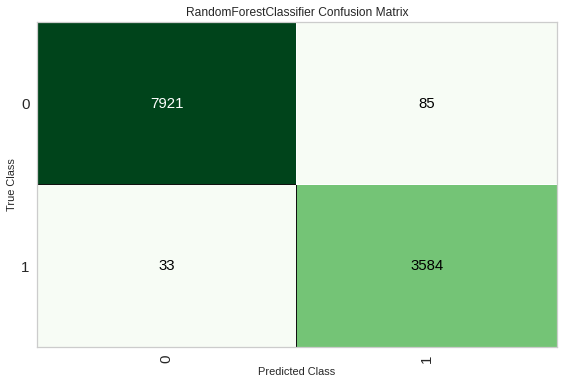

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf, plot = 'confusion_matrix')

In [ ]:
evaluate_model(tuned_rf)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
final_rf = finalize_model(tuned_rf)

print(final_rf)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
             

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


In [ ]:
unseen_predictions = predict_model(final_rf, data=data_unseen)
unseen_predictions.head(10)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Random Forest Classifier    0.9936  0.9998  0.9935  0.9855  0.9895  0.9849   

      MCC  
0  0.9849

BDEP        TPO          HL     BHT    WOB  Annotation  Label   Score
0  0.000  17.699526  526.521986  19.347   9.37           0      0  0.9994
1 -0.203  13.472774  522.449986  20.093  13.44           0      0  0.9995
2  0.000  19.020387  524.481986  23.530  11.41           0      0  0.9994
3 -0.172  14.529462  524.067986  24.047  11.82           0      0  0.9996
4 -0.178  18.492043  525.657986  24.484  10.23           0      0  0.9996
5 -0.250  23.511311  522.349986  25.337  13.54           0      0  0.9995
6 -0.176  22.190451  523.105986  25.513  12.78           0      0  0.9996
7 -0.173  21.133763  526.107986  28.147   9.78           0      0  0.9996
8  0.000  21.133763  524.609986  28.579  11.28           0      0  0.9994
9 -0.163  23.511311  528.517986  29.768   7.37           0      0  0.9998

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['Annotation'], unseen_predictions['Label'], metric = 'Accuracy')

0.9936

In [ ]:
save_model(final_rf,'Intelie_by_Viasat Challenge Model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), model_name=Intelie_by_Viasat Challenge Model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
      

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Annotation', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_s...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight='balanced_subsample',
                                         criterion='entropy', max_depth=4,
                                         max_featur

## Binary Classification with H2o

In [ ]:
df['Annotation'].value_counts()

0    27841
1    12941
Name: Annotation, dtype: int64

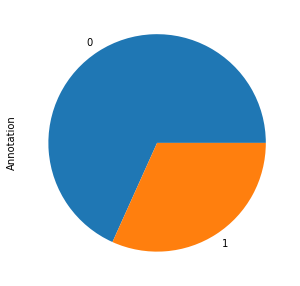

In [ ]:
df['Annotation'].value_counts().plot.pie(y='distrib', figsize=(5, 5))

We can see that we have a inbalanced dataset, with almost 3/4 of one kind of label. I'll test two approaches to our models, 50/50 reduced dataset and a balance the dataset using SMOTEtomek, that will generate more samples.

In [ ]:
X = df.drop(['Annotation'], axis=1)
y = df[['Annotation']]

In [ ]:
smt = SMOTETomek(random_state=42)

X_res, y_res = smt.fit_resample(X, y)

In [ ]:
X = X_res
y = y_res

In [ ]:
preproc = X
preproc['Annotation'] = y 

In [ ]:
preproc['Annotation'].value_counts()

0    27732
1    27732
Name: Annotation, dtype: int64

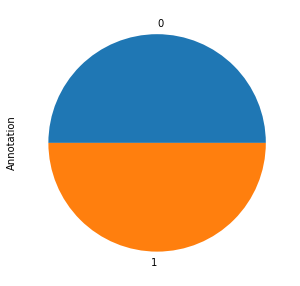

In [ ]:
preproc['Annotation'].value_counts().plot.pie(y='distrib', figsize=(5, 5))

Here i'll normalize all values between 0-1 to improve our model performance.

In [ ]:
def Normalization(df, col):
  X_med = df[col].to_numpy()
  normalizer = Normalizer().fit([X_med])
  result = normalizer.transform([X_med])
  df[col] = result.reshape(-1)

In [ ]:
for x in X:
  if x != 'Annotation':
    Normalization(X, x)

## Feature selection

I'll test models with all features and some with feature selection. For this test will be used de Sequential Feature Selecton method, forward(adding features)and backward(removing features), also will be using 2 types of estimators (Ridge Classifier and Logistic Regression). At each stage, this estimators chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

### RidgeClassifier

Forward

In [ ]:
estimator = RidgeClassifier(max_iter=10000)
sfs_selector = SequentialFeatureSelector(estimator=estimator, cv = 10)
sfs_selector.fit(X, np.array(y))

print(f"Main features:")
display(sfs_selector.estimator.get_params())
display(X.columns[sfs_selector.get_support()])

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridg

Main features:


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

Index(['BHT', 'WOB'], dtype='object')

Backward

In [ ]:
sfs_selector = SequentialFeatureSelector(estimator=estimator, cv =10, direction ='backward')
sfs_selector.fit(X, y)
X.columns[sfs_selector.get_support()]

print(f"Main features:")
display(sfs_selector.estimator.get_params())
display(X.columns[sfs_selector.get_support()])

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridg

Main features:


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

Index(['HL', 'BHT'], dtype='object')

### LogisticRegression

Forward

In [ ]:
estimator = LogisticRegression(max_iter=10000)
sfs_selector = SequentialFeatureSelector(estimator=estimator, cv = 10)
sfs_selector.fit(X, y)

print(f"Main features:")
display(sfs_selector.estimator.get_params())
display(X.columns[sfs_selector.get_support()])

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1141

Main features:


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Index(['BHT', 'WOB'], dtype='object')

Backward

In [ ]:
sfs_selector = SequentialFeatureSelector(estimator=estimator, cv=10, direction ='backward', n_jobs=-1)
sfs_selector.fit(X, y)

print(f"Main features:")
display(sfs_selector.estimator.get_params())
display(X.columns[sfs_selector.get_support()])

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Main features:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Index(['HL', 'BHT'], dtype='object')

## H2o

In [ ]:
first_run = False

if 'google.colab' in str(get_ipython()):
  print("Running in colab...")
  
  !pip install h2o

  from google.colab import drive
  drive.mount('/content/drive')

  train_all_features = '/content/drive/MyDrive/Viasat_challenge/data/dataset_v2.csv'
  path_models = '/content/drive/MyDrive/Viasat_challenge/models'

else:
  if first_run:
    !pip install h2o
    !pip install pandas
    !pip install sklearn
    !pip install matplotlib
  
  print("Running locally...")
  
  #if needs to test local 
  train_all_features = f""
  path_models = f""

Running in colab...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.38.0.4-py2.py3-none-any.whl size=177628739 sha256=b14b16eb1eaf220ded36bf0aec7274a024ba2a1690032f9d21d355a67863b724
  Stored in directory: /root/.cache/pip/wheels/6b/1d/65/39927b5984bde22f615b4c6e9a8ee98ea4abf1acb5926623ff
Successfully built h2o
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt3bnyokr
  JVM stdout: /tmp/tmpt3bnyokr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpt3bnyokr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.4
H2O_cluster_version_age:    15 days
H2O_cluster_name:           H2O_from_python_unknownUser_psqyvz
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.172 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.10 final
--------------------------  ----------------------------------

In [ ]:
df = h2o.import_file(train_all_features, header=0)
df = df.drop([0])
df["Annotation"] = df["Annotation"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
feat_dict = dict()
idx = 0
for feat in df.columns:
    feat_dict.update({idx:feat})
    idx += 1

feat_dict

{0: 'BDEP', 1: 'TPO', 2: 'HL', 3: 'BHT', 4: 'WOB', 5: 'Annotation'}

In [ ]:
def get_accuracy(model, test):
    preds = model.predict(test).as_data_frame(use_pandas=True)
    y_hat = preds["predict"]
    y = test["Annotation"].as_data_frame(use_pandas=True)
    y = y["Annotation"]

    hits = 0
    for prediction, target in zip(y_hat, y):
        if prediction == target:
            hits += 1

    return hits/len(y)

best_accuracy = 0
best_model = None
best_feature_set = None

In [ ]:
response_col = "Annotation"

def apply_autoML_for(training):
    aml = H2OAutoML(max_runtime_secs=0, seed=42, nfolds=10)
    display(training)
    aml.train(y=response_col, training_frame=training)
    return aml

As both estimators selected the same features in the same selection directions, only 1 test batch will be needed

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_allFeats

BDEP       TPO       HL     BHT     WOB  Annotation
------  --------  -------  ------  ------  ------------
 0       37.2483  448.55    2.936   20.88  off_slips
-0.183    0       454.144  15.724    7.35  off_slips
 0        0        96.414   2.048  337.9   on_slips
 0        0       409.632   8.939    2.06  off_slips
-0.172    0       429.954  15.075   -2.47  off_slips
 0      203.941   470.144  24.729    8.68  off_slips
-0.187    0       399.53    7.787    2.49  off_slips
 0        0        95.518   2.019  338.79  on_slips
 0        0       361.486  39.341   10.49  off_slips
 0        0       377.308  23.086    0.24  off_slips
[36703 rows x 6 columns]

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_allFeats-GBM_1_AutoML_1_20230120_203959-acc:0.9901936749203236

### Best Model Saved To: /content/drive/MyDrive/Viasat_challenge/models/df_allFeats-GBM_1_AutoML_1_20230120_203959-acc:0.9901936749203236

### df_allFeats has accuracy: 0.9901936749203236

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20230120_203959


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    113                113                         163567                 6            15           14.8938       15            155           109.903

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0034089969666173474
RMSE: 0.05838661633129075
LogLoss: 0.011136802193851823
Mean Per-Class Error: 0.005138440952625011
AUC: 0.9999249041981113
AUCPR: 0.9998395550284636
Gini: 0.9998498083962226

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47625176312474204
           off_slips    on_slips    Error    Rate
---------  -----------  ----------  -------  ---------------
off_slips  24962        94          0.0038   (94.0/25056.0)
on_slips   76           11571       0.0065   (76.0/11647.0)
Total      25038        11665       0.0046   (170.0/36703.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476252     0.992708  205
max f2                       0.251155     0.994989  279
max f0point5                 0.718633     0.995196  128
max accuracy                 0.476252     0.995368  205
max precision                0.999982     1         0
max recall                   0.130899     1         319
max specificity              0.999982     1         0
max absolute_mcc             0.476252     0.989315  205
max min_per_class_accuracy   0.40778      0.994852  223
max mean_per_class_accuracy  0.304119     0.995038  259
max tns                      0.999982     25056     0
max fns                      0.999982     2018      0
max fps                      5.02066e-06  25056     399
max tps                      0.130899     11647     319
max tnr                      0.999982     1         0
max fnr                      0.999982     0.173264  0
max fpr                      5.02066e-06  1         399
max tpr                      0.130899     1         319

Gains/Lift Table: Avg response rate: 31.73 %, avg score: 31.74 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100264                   0.999992           3.15128   3.15128            1                0.999992     1                           0.999992            0.0315961       0.0315961                  215.128   215.128            0.0315961
2        0.0200256                   0.999992           3.15128   3.15128            1                0.999992     1                           0.999992            0.0315103       0.0631064                  215.128   215.128            0.0631064
3        0.0300248                   0.999991           3.15128   3.15128            1                0.999992     1                           0.999992            0.0315103       0.0946166                  215.128   215.128            0.0946166
4        0.040024                    0.999991           3.15128   3.15128            1                0.999991     1                           0.999992            0.0315103       0.126127                   215.128   215.128            0.126127
5        0.0503774                   0.9

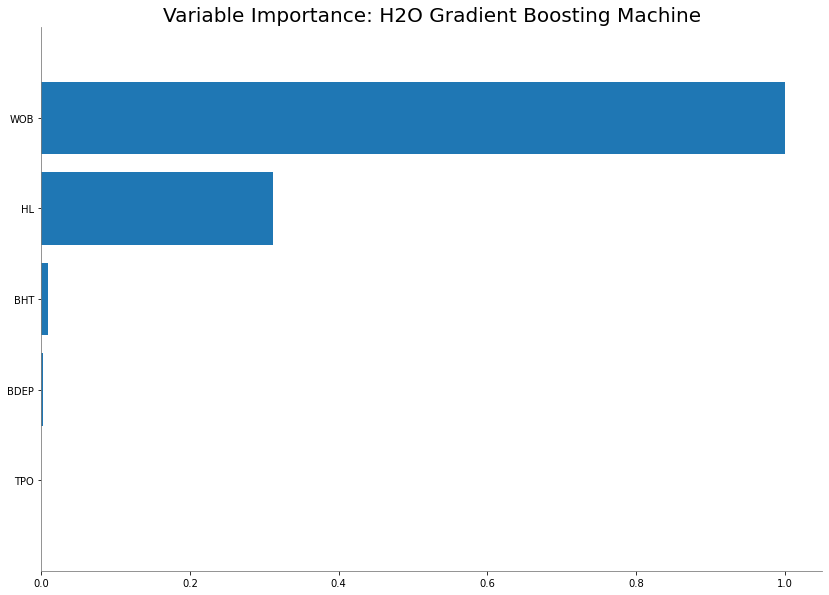

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFS_RidgeClassifier_Forward

BHT     WOB  Annotation
------  ------  ------------
39.072   27.86  off_slips
15.626   -2.46  off_slips
39.187  350.44  on_slips
27.16    10.81  off_slips
39.346   24.91  off_slips
11.628  372.95  on_slips
13.949  322.74  on_slips
 3.624    9.55  off_slips
32.471   -8.32  off_slips
31.939   -1.66  off_slips
[36703 rows x 3 columns]

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### df_SFS_RidgeClassifier_Forward has accuracy: 0.9897033586663397

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_2_20230120_214004_model_5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    82                 82                          159795                 9            9            9             53            238           150.622

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0015084438647808148
RMSE: 0.03883869030722863
LogLoss: 0.006349432878666429
Mean Per-Class Error: 0.001644061785159241
AUC: 0.9999912893667168
AUCPR: 0.9999812707080308
Gini: 0.9999825787334335

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5291020066450202
           off_slips    on_slips    Error    Rate
---------  -----------  ----------  -------  --------------
off_slips  25036        20          0.0008   (20.0/25056.0)
on_slips   29           11618       0.0025   (29.0/11647.0)
Total      25065        11638       0.0013   (49.0/36703.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529102     0.997896  202
max f2                       0.360062     0.998611  244
max f0point5                 0.613762     0.998175  181
max accuracy                 0.529102     0.998665  202
max precision                0.999729     1         0
max recall                   0.207559     1         291
max specificity              0.999729     1         0
max absolute_mcc             0.529102     0.996918  202
max min_per_class_accuracy   0.463965     0.998523  220
max mean_per_class_accuracy  0.417915     0.998576  231
max tns                      0.999729     25056     0
max fns                      0.999729     9036      0
max fps                      0.000133125  25056     399
max tps                      0.207559     11647     291
max tnr                      0.999729     1         0
max fnr                      0.999729     0.775822  0
max fpr                      0.000133125  1         399
max tpr                      0.207559     1         291

Gains/Lift Table: Avg response rate: 31.73 %, avg score: 31.73 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0106258                   0.999732           3.15128   3.15128            1                0.999732     1                           0.999732            0.033485        0.033485                   215.128   215.128            0.033485
2        0.0200529                   0.999732           3.15128   3.15128            1                0.999732     1                           0.999732            0.0297072       0.0631922                  215.128   215.128            0.0631922
3        0.0456366                   0.999732           3.15128   3.15128            1                0.999732     1                           0.999732            0.0806216       0.143814                   215.128   215.128            0.143814
4        0.0500504                   0.999729           3.15128   3.15128            1                0.99973      1                           0.999732            0.0139092       0.157723                   215.128   215.128            0.157723
5        0.100019               

<Figure size 432x288 with 0 Axes>

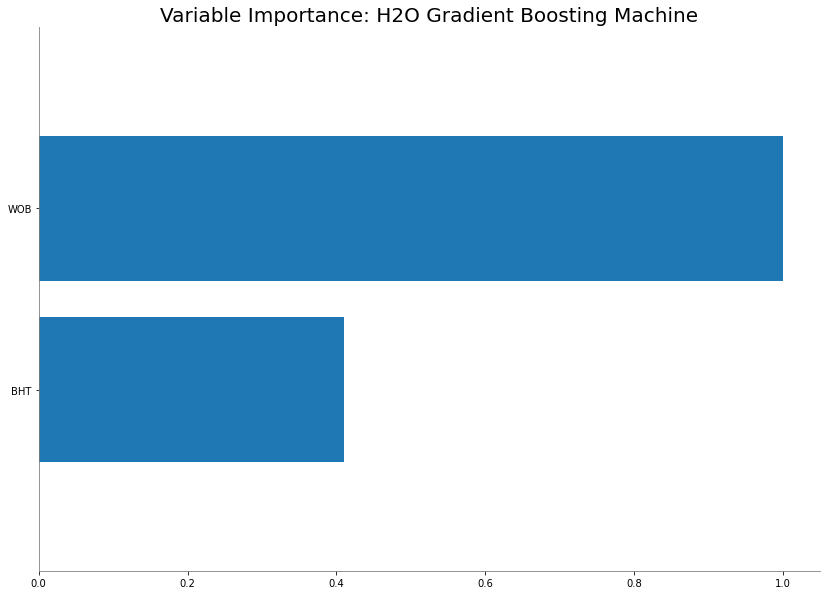

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFS_RidgeClassifier_Backward

HL     BHT  Annotation
-------  ------  ------------
378.68    4.354  off_slips
424.192  33.246  off_slips
131.102  39.241  on_slips
496.102  39.559  off_slips
418.814  19.212  off_slips
447.206  39.753  off_slips
487.056  23.431  off_slips
 92.956  10.72   on_slips
414.096   4.939  off_slips
422.268   3.621  off_slips
[36703 rows x 3 columns]

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### df_SFS_RidgeClassifier_Backward has accuracy: 0.9897033586663397

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_3_20230120_224011_model_14


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    121                121                         35165                  6            6            6             12            29            18.5124

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.005039080420058922
RMSE: 0.07098648054424815
LogLoss: 0.01615289199049344
Mean Per-Class Error: 0.008101241901920929
AUC: 0.9998179419390169
AUCPR: 0.9996146145640561
Gini: 0.9996358838780337

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433485128519792
           off_slips    on_slips    Error    Rate
---------  -----------  ----------  -------  ---------------
off_slips  24934        122         0.0049   (122.0/25056.0)
on_slips   132          11515       0.0113   (132.0/11647.0)
Total      25066        11637       0.0069   (254.0/36703.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433485     0.989091  206
max f2                       0.228174     0.991742  278
max f0point5                 0.827115     0.992822  93
max accuracy                 0.433485     0.99308   206
max precision                0.999974     1         0
max recall                   0.0362068    1         366
max specificity              0.999974     1         0
max absolute_mcc             0.433485     0.984024  206
max min_per_class_accuracy   0.329105     0.992015  239
max mean_per_class_accuracy  0.256178     0.992285  265
max tns                      0.999974     25056     0
max fns                      0.999974     3999      0
max fps                      1.22334e-05  25056     399
max tps                      0.0362068    11647     366
max tnr                      0.999974     1         0
max fnr                      0.999974     0.34335   0
max fpr                      1.22334e-05  1         399
max tpr                      0.0362068    1         366

Gains/Lift Table: Avg response rate: 31.73 %, avg score: 31.71 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0118519                   0.999992           3.15128   3.15128            1                0.999992     1                           0.999992            0.0373487       0.0373487                  215.128   215.128            0.0373487
2        0.0292074                   0.999992           3.15128   3.15128            1                0.999992     1                           0.999992            0.0546922       0.0920409                  215.128   215.128            0.0920409
3        0.0305425                   0.999991           3.15128   3.15128            1                0.999991     1                           0.999992            0.00420709      0.096248                   215.128   215.128            0.096248
4        0.0423944                   0.999991           3.15128   3.15128            1                0.999991     1                           0.999992            0.0373487       0.133597                   215.128   215.128            0.133597
5        0.055881             

<Figure size 432x288 with 0 Axes>

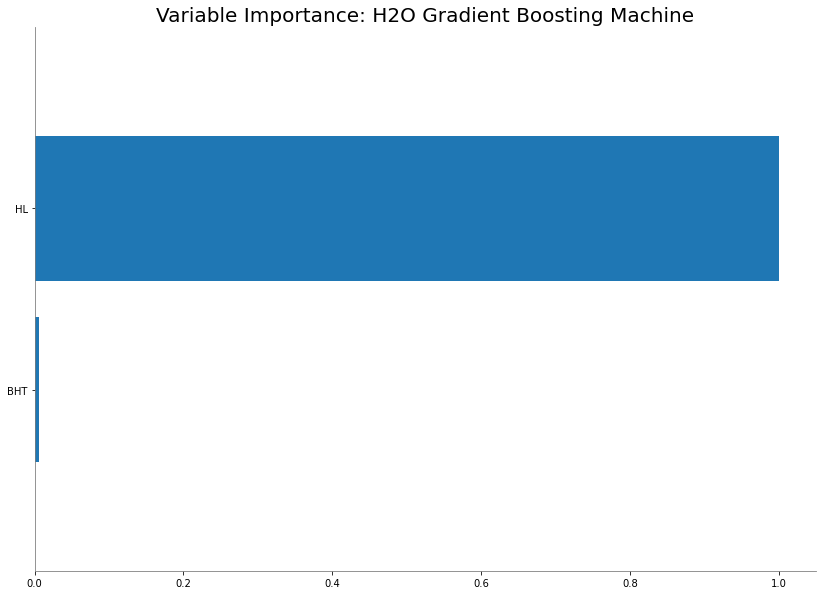

<Figure size 432x288 with 0 Axes>

In [ ]:
all_Feats = [0, 1, 2, 3, 4, 5]
SFS_RidgeClassifier_Forward = [3, 4, 5]
SFS_RidgeClassifier_Backward = [2, 3, 5] 


df_allFeats = df[all_Feats]
df_SFS_RidgeClassifier_Forward = df[SFS_RidgeClassifier_Forward]
df_SFS_RidgeClassifier_Backward = df[SFS_RidgeClassifier_Backward]


feature_combinations = {
    'df_allFeats' : df[all_Feats],
    'df_SFS_RidgeClassifier_Forward' : df[SFS_RidgeClassifier_Forward],
    'df_SFS_RidgeClassifier_Backward' : df[SFS_RidgeClassifier_Backward]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["Annotation"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

So it's conclude that the WOB (Weight on Bit) is the most important feature to determine if the slips is on or off. How slips is a device used to grip and hold the upper part of a drill string to the drill floor on an oil rig, intuitively we came to the conclusion that for a high wob value the presence of slips is necessary.